## 读取数据

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False  # 负号正常显示
# 读取收盘价
with open('frdata/stock_close.pkl', 'rb') as f:
    stock_close = pickle.load(f)  # DataFrame: index=日期, columns=股票代码

# 读取日收益率
with open('frdata/stock_return.pkl', 'rb') as f:
    stock_return = pickle.load(f)  # DataFrame: index=日期, columns=股票代码

# 读取交易日历
with open('frdata/all_dates.pkl', 'rb') as f:
    all_dates = pickle.load(f)  # List[str]

# 读取指数成分
with open('frdata/index_dict.pkl', 'rb') as f:
    index_dict = pickle.load(f)  # dict

with open('frdata/stock_totalmv.pkl', 'rb') as f:
    stock_totalmv = pickle.load(f)
# 读取行业
with open('frdata/stock_ind.pkl', 'rb') as f:
    stock_ind = pickle.load(f)

## 2.1 个股的动量效应统计

In [2]:
# 2.1 个股的动量效应统计

# 选取每月最后一个交易日
start_date = '2010-01-01'
end_date = '2022-05-31'

valid_dates = [d for d in stock_return.index if (d >= start_date and d <= end_date)]
month_ends = sorted(list(set([d[:7] for d in valid_dates])))
month_end_dates = [max([d for d in valid_dates if d[:7] == m]) for m in month_ends]

In [3]:
# 2.1(1)
# 反转因子：过去20日收益率均值
stock_return = stock_close.pct_change()
reversal_factor = stock_return.rolling(20).mean().loc[month_end_dates]

# 下一期收益率：未来20日收益率均值
#future_return = stock_return.shift(-20).rolling(20).mean().loc[month_end_dates]
#print(future_return.head())
future_return = stock_return.rolling(20).mean().shift(-20).loc[month_end_dates]
print(future_return.head())

              000001    000002    000004    000005    000006    000007  \
index                                                                    
2010-01-29  0.003687  0.000193  0.004698  0.006831  0.002240  0.004644   
2010-02-26  0.000939 -0.000617  0.004176  0.003294  0.007010 -0.002394   
2010-03-31 -0.006681 -0.009829 -0.001866 -0.009252 -0.010369  0.004498   
2010-04-30 -0.007539 -0.003494 -0.006654 -0.003994 -0.022824 -0.007331   
2010-05-31  0.000313 -0.003668 -0.003369 -0.006371 -0.002856 -0.000126   

              000008    000009    000010    000011  ...  920098  920099  \
index                                               ...                   
2010-01-29  0.010143  0.005237  0.004731  0.004006  ...     NaN     NaN   
2010-02-26  0.005323  0.000193  0.006234  0.007647  ...     NaN     NaN   
2010-03-31 -0.000752 -0.001917  0.003182 -0.017195  ...     NaN     NaN   
2010-04-30  0.005746 -0.005792  0.000000 -0.006700  ...     NaN     NaN   
2010-05-31 -0.017735 -0.009792 

In [4]:
# 2.1(2)
# 计算每期的截面均值
factor_mean = reversal_factor.mean(axis=1)
future_return_mean = future_return.mean(axis=1)
# 2.1(3)
# 得到超额因子值和超额收益率
factor_excess = reversal_factor.sub(factor_mean, axis=0)
future_return_excess = future_return.sub(future_return_mean, axis=0)

In [9]:
#net_momentum_ratio = []
#for date in month_end_dates:
#    x = factor_excess.loc[date]
#    y = future_return_excess.loc[date]
#    valid = x.notna() & y.notna()
#    x = x[valid]
#    y = y[valid]
#    # 动量效应：每天符号一致的股票数
#    momentum = ((x * y) > 0).sum()
#    # 反转效应：符号相反的股票数
#    reversal = ((x * y) < 0).sum()
#    total = valid.sum() # valid的总股票数
#    if total > 0:
#        net_ratio = (momentum - reversal) / total
#    else:
#        net_ratio = np.nan
#    net_momentum_ratio.append(net_ratio) # 每一日净动量比例

# 向量化
net_momentum_ratio = []
x = factor_excess.loc[month_end_dates]
y = future_return_excess.loc[month_end_dates]
valid = x.notna() & y.notna()

# 按行计算每个日期的统计量
momentum = ((x * y) > 0).sum(axis=1)  
#print(momentum)
reversal = ((x * y) < 0).sum(axis=1)  
#print(reversal)
total = valid.sum(axis=1)             
#print(total)

# 向量化计算净比例
net_ratio = np.where(total > 0, (momentum - reversal) / total, np.nan)
net_momentum_ratio = net_ratio.tolist()  # 转换为列表
print(net_momentum_ratio)

[-0.0398098633392751, -0.08231173380035026, -0.11327231121281464, 0.07536557930258718, -0.04756637168141593, -0.1542234332425068, 0.06602254428341385, 0.10359408033826638, 0.05323590814196242, -0.08912931478619268, -0.14531645569620252, -0.07438841737393909, -0.06483300589390963, -0.032571706368497814, 0.05798479087452472, 0.04421448730009407, -0.15813953488372093, -0.04044117647058824, 0.11978221415607986, -0.11759425493716337, -0.152, 0.00530035335689046, 0.02712160979877515, -0.2708333333333333, -0.22538860103626943, -0.04243463351907415, -0.13432835820895522, 0.004647232784114913, 0.04438860971524288, 0.04282744282744283, -0.19769357495881384, -0.0796243364638628, -0.0958570268074736, 0.09627831715210355, -0.1693548387096774, -0.008870967741935484, 0.021774193548387097, 0.06532258064516129, -0.02815768302493966, -0.11504424778761062, 0.07958199356913183, 0.007234726688102894, -0.06993569131832797, -0.07877813504823152, -0.10209003215434084, -0.056649256729610284, 0.0269184411410204

In [10]:
# 2.1(5)
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}") #衡量动量/反转效应的“稳定性”或“显著性”。 绝对值越大，说明这种效应不仅普遍，而且波动小、稳定性强，更值得信赖。

均净动量比例: -0.0255
稳净动量比例: -0.2149


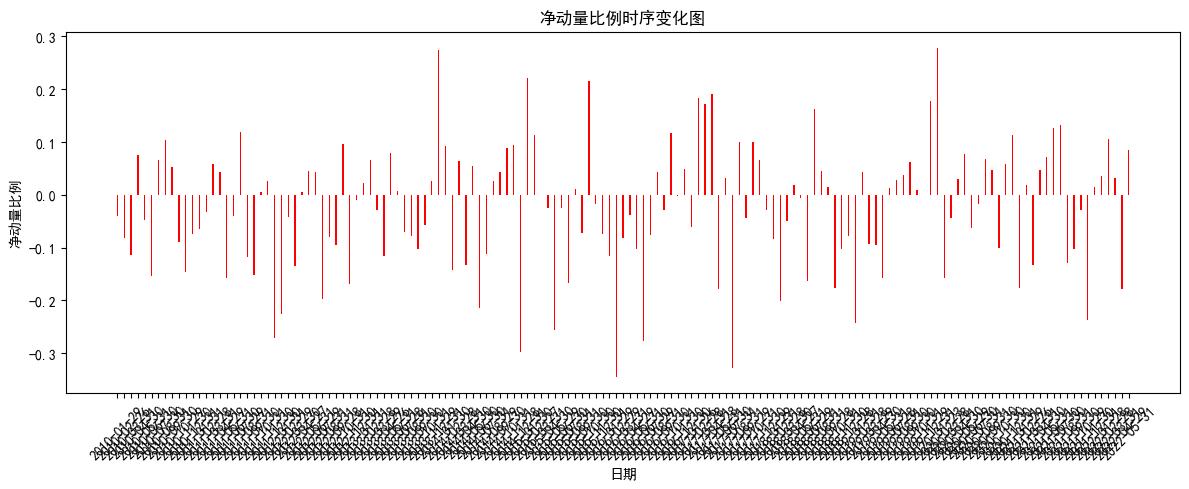

In [11]:
# 净动量比例时序变化图
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12,5))
plt.bar(month_end_dates, net_momentum_ratio, color='red', width=0.2)
plt.title('净动量比例时序变化图')
plt.xlabel('日期')
plt.ylabel('净动量比例')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

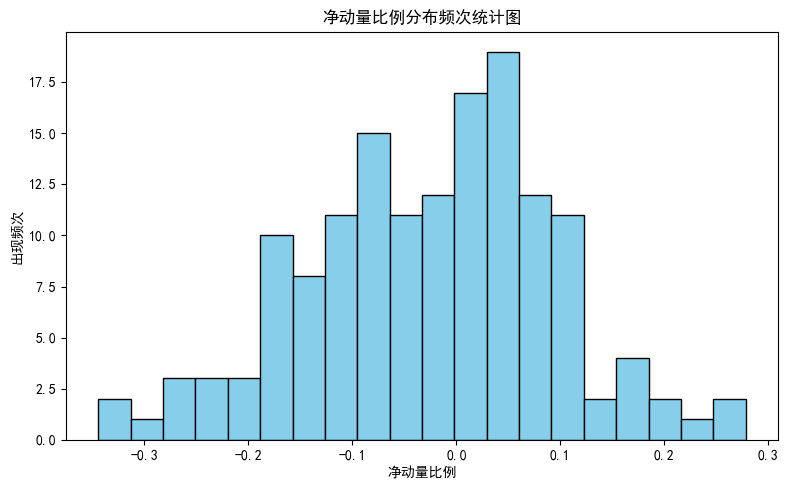

In [12]:
# 频次图
plt.figure(figsize=(8,5))
plt.hist(net_momentum_ratio, bins=20, color='skyblue', edgecolor='black')
plt.title('净动量比例分布频次统计图')
plt.xlabel('净动量比例')
plt.ylabel('出现频次')
plt.tight_layout()
plt.show()

## 2.4 “日间反转-波动翻转”因子

In [13]:
# 2.4 传统反转因子
# 1. index转为字符串
reversal_factor.index = reversal_factor.index.astype(str)

# 2. columns转为6位字符串
reversal_factor.columns = reversal_factor.columns.map(lambda x: str(x).zfill(6))

# 3. 只保留2010-01-01到2022-05-31
reversal_factor = reversal_factor.loc[
    (reversal_factor.index >= '2010-01-01') & (reversal_factor.index <= '2022-05-31')
]

# 4. 赋值给factor_df
factor_df = reversal_factor.copy()
print(factor_df.head())

              000001    000002    000004    000005    000006    000007  \
index                                                                    
2010-01-29 -0.005431 -0.007182  0.000000 -0.005093 -0.006142 -0.000457   
2010-02-26 -0.001174 -0.000532  0.002016 -0.000109 -0.000211  0.004065   
2010-03-31 -0.000059 -0.000334  0.000733  0.001338  0.006494 -0.001340   
2010-04-30 -0.006145 -0.010782 -0.004518 -0.011496 -0.012213  0.003174   
2010-05-31 -0.007539 -0.003494 -0.006654 -0.003994 -0.022824 -0.007331   

              000008    000009    000010    000011  ...  920098  920099  \
index                                               ...                   
2010-01-29 -0.011882 -0.002081 -0.001631 -0.003954  ...     NaN     NaN   
2010-02-26  0.001318  0.000759  0.000880 -0.004732  ...     NaN     NaN   
2010-03-31  0.004797 -0.000112  0.002908  0.005722  ...     NaN     NaN   
2010-04-30 -0.003053 -0.003831  0.001877 -0.019000  ...     NaN     NaN   
2010-05-31  0.005746 -0.005792 

In [26]:
# 对因子做市值+行业中性化
#factor_df_neu = config.neutralize(
#    factor_df,      # 因子面板，index为日期，columns为股票代码
#    ind=True,       # 申万一级行业中性
#    barrasize=True, # barra的size和sizenl中性
#    barraall=False, # 不用10因子全中性
#    ret=False,      # 不对收益做中性
#    ret_win=20,     # 仅在ret=True时生效
#    path='frdata'   # 本地数据路径，通常不用改
#)

load data locally from 2009-01-05 to 2025-04-15


load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016    2017   2018  \
年化超额   0.2708 -0.2761 0.1929 0.3701 0.5847 0.1508 0.1261 -0.0993 0.0895   
波动率     0.2673  0.2566 0.2781 0.2364 0.1896 0.0726 0.0535  0.0698 0.0704   
最大回撤   0.2964  0.3910 0.2692 0.1568 0.1392 0.0439 0.0531  0.1311 0.0649   
夏普率     1.0130 -1.0761 0.6938 1.5656 3.0829 2.0774 2.3598 -1.4229 1.2711   
收益回撤比 0.9138 -0.7062 0.7167 2.3602 4.2017 3.4324 2.3754 -0.7573 1.3788   
半波       0.1707  0.1674 0.1642 0.1455 0.1176 0.0342 0.0297  0.0465 0.0411   
半夏普     1.5869 -1.6495 1.1752 2.5435 4.9729 4.4037 4.2502 -2.1354 2.1791   

              2019    2020   2021   2022   mean  
年化超额   -0.0053 -0.0024 0.0353 0.0739 0.1162  
波动率      0.0543  0.0645 0.1001 0.0841 0.1383  
最大回撤    0.0515  0.0658 0.1011 0.0392 0.3910  
夏普率     -0.0973 -0.0376 0.35

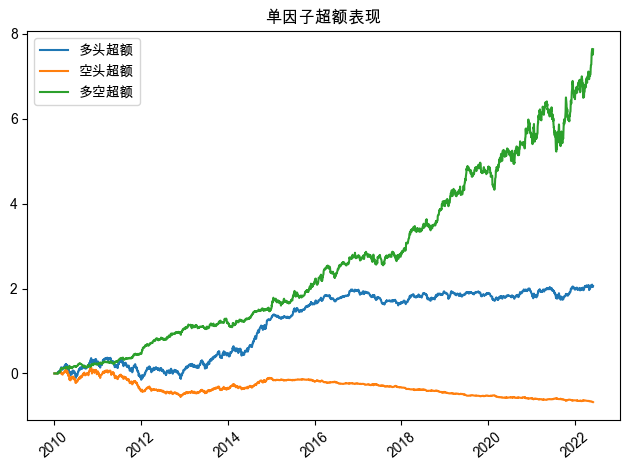

平均单边换手：0.804
年化交易成本:0.033 (未在超额中扣除)


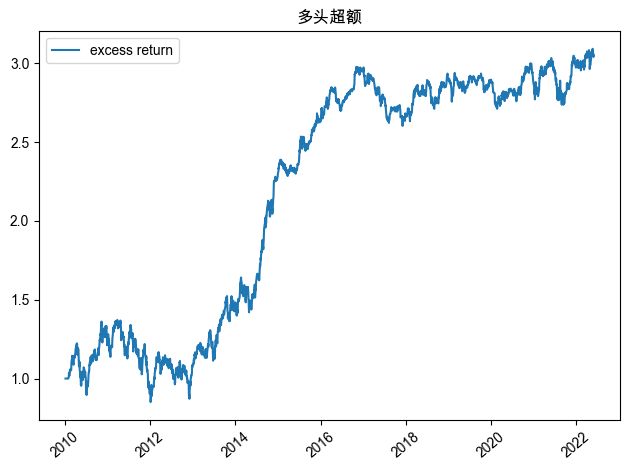

In [49]:
# 传统反转因子回测
import config
pkg_path=r'/Users/chenchen/Desktop/mycuhk/兴银/需要拷的数据/'
res = config.backtest_stand(
    -factor_df,
    fre='month',
    stock_pool='888888',
    benchmark='b4',
    barra_neutral=True, # 中性化
    top=300,
    localdata_path=pkg_path+'packages/frdata',
    start='2010-01-01',
    end='2022-05-31'
)

In [50]:
# continue
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

Rank IC: 6.02%
Rank ICIR: 0.63
t值: 7.69
年化收益率: 11.62%
年化波动率: 13.83%
信息比率: 0.84
夏普比率: 0.84
最大回撤: 39.10%


In [14]:
# 2.4 准备构建日间反转-波动翻转因子
import pandas as pd
import numpy as np
from config import load_data_local, prepare_dates, neutralize, backtest_stand
import pickle
def calculate_daily_returns(stock_close):
    """
    计算日间收益率
    """
    return stock_close.pct_change()

def calculate_monthly_volatility(daily_returns, window=20):
    """
    计算月波动率
    """
    # 计算20天窗口的波动率
    volatility = daily_returns.rolling(window=window).std()
    return volatility

def calculate_monthly_returns(daily_returns, window=20):
    """
    计算月收益率
    """
    # 计算20天窗口的平均收益率
    returns = daily_returns.rolling(window=window).mean()
    return returns

def construct_reversal_volatility_factor(stock_close, start_date, end_date):
    """
    构建日间反转-波动翻转因子
    """
    # 1. 计算日间收益率
    daily_returns = calculate_daily_returns(stock_close)
    
    # 2. 计算月波动率和月收益率
    monthly_volatility = calculate_monthly_volatility(daily_returns)
    monthly_returns = calculate_monthly_returns(daily_returns)
    
    # 3. 获取月末日期
    month_end_dates = prepare_dates(start_date, end_date, fre='month')
    
    # 4. 构建因子
    factor_df = pd.DataFrame(index=month_end_dates, columns=stock_close.columns)
    
    #for date in month_end_dates:
    #    # 获取当月的波动率和收益率
    #    vol = monthly_volatility.loc[date]
    #    ret = monthly_returns.loc[date]
    #    
    #    # 计算市场截面均值
    #    market_vol_mean = vol.mean()
    #    
    #    # 根据波动率大小决定是否翻转因子值
    #    factor_values = ret.copy()
    #    factor_values[vol < market_vol_mean] *= -1  # 波动率小于均值的股票翻转因子值
    #    
    #    factor_df.loc[date] = factor_values
    
    # 向量化
    vol_data = monthly_volatility.loc[month_end_dates]
    ret_data = monthly_returns.loc[month_end_dates]
    # 计算市场截面均值
    market_vol_mean = vol_data.mean(axis=1)
    factor_values = np.where(
        vol_data.lt(market_vol_mean, axis=0),  
        -ret_data,                             
        ret_data                               
    )
    factor_df.loc[month_end_dates] = pd.DataFrame(
        factor_values, 
        index=month_end_dates, 
        columns=ret_data.columns
    )
    
    return factor_df

def calculate_momentum_ratio(factor_df, future_return_df):
    """
    计算净动量比例（按行遍历，for循环一致）
    factor_df: DataFrame, index为日期，columns为股票
    future_return_df: DataFrame, index为日期，columns为股票（未来收益）
    返回：Series，index为日期，值为净动量比例
    """
    # 计算每期的截面均值
    factor_mean = factor_df.mean(axis=1)
    future_return_mean = future_return_df.mean(axis=1)
    # 得到超额因子值和超额收益率
    factor_excess = factor_df.sub(factor_mean, axis=0)
    future_return_excess = future_return_df.sub(future_return_mean, axis=0)
    net_momentum_ratio = []
    #for date in factor_df.index:
    #    x = factor_excess.loc[date]
    #    y = future_return_excess.loc[date]
    #    valid = x.notna() & y.notna()
    #    x = x[valid]
    #    y = y[valid]
    #    # 动量效应：符号一致的股票数
    #    momentum = ((x * y) > 0).sum()
    #    # 反转效应：符号相反的股票数
    #    reversal = ((x * y) < 0).sum()
    #    total = valid.sum()
    #    if total > 0:
    #        net_ratio = (momentum - reversal) / total
    #    else:
    #        net_ratio = np.nan
    #    net_momentum_ratio.append(net_ratio)

    # 向量化
    x = factor_excess.loc[factor_df.index]
    y = future_return_excess.loc[factor_df.index]
    valid = x.notna() & y.notna()
    product = x * y

    momentum = ((product > 0) & valid).sum(axis=1)
    reversal = ((product < 0) & valid).sum(axis=1)
    total = valid.sum(axis=1)

    net_momentum_ratio = np.where(
        total > 0,                           
        (momentum - reversal) / total,       
        np.nan                               
    ).tolist()

    return pd.Series(net_momentum_ratio, index=factor_df.index)

def analyze_factor_performance(factor_df, start_date, end_date):
    """
    分析因子表现
    """
    # 1. 因子中性化
    # ?与backtest_stand中的barra_neutral=True相同？
    neutralized_factor = neutralize(factor_df, ind=True, barrasize=True)
    
    # 2. 回测
    res = backtest_stand(-neutralized_factor, 
                        start=start_date,
                        end=end_date,
                        benchmark='b4',
                        stock_pool='888888',
                        #barra_neutral=True,
                        fre='month',
                        top=300)
    # Rank IC
    rank_ic = res['ic']['ic'].mean()
    # Rank ICIR
    rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
    # t值
    t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
    perf = res['多空表现']['多头表现']  
    annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
    annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
    info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
    #win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
    max_drawdown = perf.loc['最大回撤', 'mean']
    print(f"Rank IC: {rank_ic:.2%}")
    print(f"Rank ICIR: {rank_icir:.2f}")
    print(f"t值: {t_value:.2f}")
    print(f"年化收益率: {annual_return:.2%}")
    print(f"年化波动率: {annual_vol:.2%}")
    print(f"信息比率: {info_ratio:.2f}")
    #print(f"月度胜率: {win_rate:.2%}")
    print(f"最大回撤: {max_drawdown:.2%}")
    return res


load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016    2017   2018  \
年化超额   0.3092 -0.2833 0.2322 0.4045 0.7273 0.1581 0.1666 -0.0458 0.1400   
波动率     0.2735  0.2549 0.2766 0.2430 0.1911 0.0751 0.0481  0.0709 0.0716   
最大回撤   0.2936  0.3940 0.2365 0.1503 0.1299 0.0694 0.0411  0.0790 0.0511   
夏普率     1.1303 -1.1114 0.8395 1.6647 3.8060 2.1039 3.4657 -0.6466 1.9558   
收益回撤比 1.0530 -0.7190 0.9817 2.6922 5.5979 2.2764 4.0582 -0.5799 2.7365   
半波       0.1732  0.1660 0.1630 0.1473 0.1167 0.0347 0.0251  0.0483 0.0403   
半夏普     1.7845 -1.7068 1.4241 2.7467 6.2326 4.5609 6.6486 -0.9481 3.4735   

             2019   2020   2021   2022   mean  
年化超额   0.0835 0.0784 0.0935 0.0907 0.1658  
波动率     0.0533 0.0632 0.0990 0.0881 0.1391  
最大回撤   0.0487 0.0500 0.0792 0.04

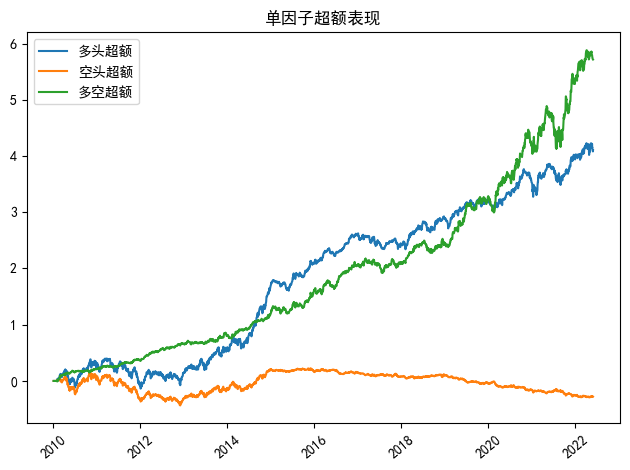

平均单边换手：0.793
年化交易成本:0.032 (未在超额中扣除)


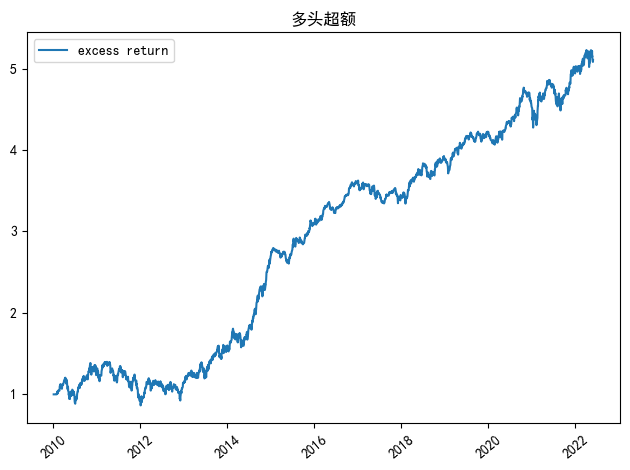

Rank IC: 4.64%
Rank ICIR: 0.77
t值: 9.32
年化收益率: 16.58%
年化波动率: 13.91%
信息比率: 1.19
最大回撤: 39.40%
均净动量比例: -0.0282
稳净动量比例: -0.3410


In [16]:
# 2.4 构建日间反转-波动翻转因子
with open(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\frdata\stock_close.pkl', 'rb') as f:
    stock_close = pickle.load(f)

# 设置回测区间
start_date = '2010-01-01'
end_date = '2022-05-31'
month_end_dates = prepare_dates(start_date, end_date, fre='month')
# 构建因子
factor_volatility = construct_reversal_volatility_factor(stock_close, start_date, end_date)

# 计算净动量比例
stock_return = calculate_daily_returns(stock_close)
future_return = stock_return.rolling(20).mean().shift(-20).loc[month_end_dates]

net_momentum_ratio = calculate_momentum_ratio(factor_volatility, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_volatility, start_date, end_date)

# 输出结果
#print("\n因子表现分析结果：")
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")


## 2.5 “日间反转-换手翻转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016   2017   2018  \
年化超额   0.3615 -0.2471 0.1482 0.4863 0.6339 0.1272 0.1958 0.0076 0.2034   
波动率     0.2561  0.2390 0.2550 0.2278 0.1775 0.0596 0.0410 0.0426 0.0487   
最大回撤   0.2868  0.3645 0.2378 0.1393 0.1067 0.0428 0.0386 0.0442 0.0293   
夏普率     1.4116 -1.0339 0.5811 2.1348 3.5714 2.1357 4.7726 0.1795 4.1815   
收益回撤比 1.2605 -0.6778 0.6232 3.4900 5.9422 2.9713 5.0776 0.1729 6.9423   
半波       0.1600  0.1564 0.1520 0.1382 0.1085 0.0270 0.0202 0.0269 0.0251   
半夏普     2.2600 -1.5801 0.9747 3.5195 5.8421 4.7043 9.6765 0.2845 8.1049   

             2019   2020   2021   2022   mean  
年化超额   0.1083 0.0545 0.0730 0.1629 0.1781  
波动率     0.0354 0.0486 0.0726 0.0773 0.1216  
最大回撤   0.0257 0.0421 0.0487 0.0265 0.364

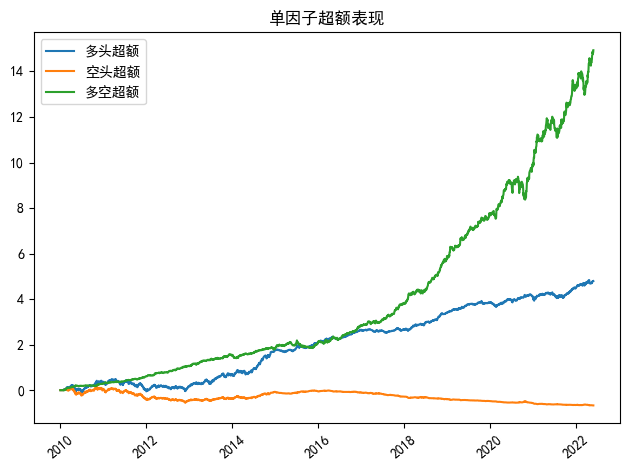

平均单边换手：0.782
年化交易成本:0.032 (未在超额中扣除)


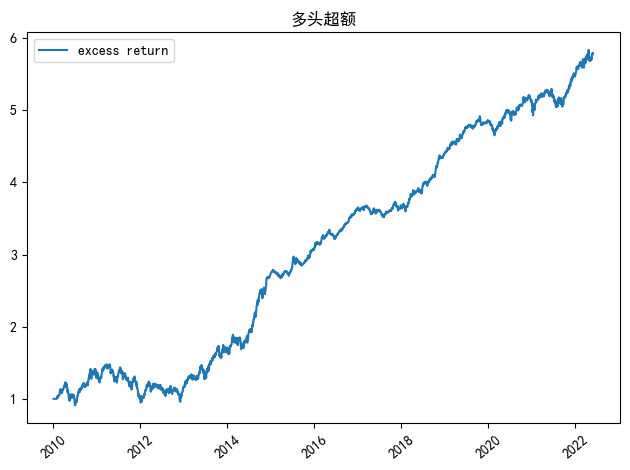

Rank IC: 7.55%
Rank ICIR: 1.20
t值: 14.62
年化收益率: 17.81%
年化波动率: 12.16%
信息比率: 1.46
最大回撤: 36.45%
均净动量比例: -0.0250
稳净动量比例: -0.2784


In [17]:
# 2.5 构建日间反转-换手翻转因子
def construct_reversal_turnover_factor(stock_close, stock_turnover, start_date, end_date):
    """
    构建日间反转-换手翻转因子
    """
    # 1. 计算日间收益率
    daily_returns = calculate_daily_returns(stock_close)
    # 2. 计算换手率变化量
    turnover_change = stock_turnover.diff()
    # 3. 获取月末日期
    month_end_dates = prepare_dates(start_date, end_date, fre='month')
    # 4. 构建翻转收益率
    flip_return = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns)
    #for date in daily_returns.index:
    #    tc = turnover_change.loc[date]
    #    market_tc_mean = tc.mean()
    #    flip = daily_returns.loc[date].copy()
    #    mask = (tc < market_tc_mean)
    #    mask = mask.reindex(flip.index)  # 对齐索引
    #    flip[mask.fillna(False)] *= -1
    #    flip_return.loc[date] = flip
    # 向量化
    tc_data = turnover_change.loc[daily_returns.index]
    returns_data = daily_returns.copy()
    market_tc_mean = tc_data.mean(axis=1)
    flip_condition = tc_data.lt(market_tc_mean, axis=0)
    flip_condition = flip_condition.reindex(columns=returns_data.columns, fill_value=False)
    flip_return_data = np.where(flip_condition.fillna(False), -returns_data, returns_data)
    flip_return.loc[daily_returns.index] = pd.DataFrame(flip_return_data, index=daily_returns.index, columns=returns_data.columns)
    # 5. 每月月底，计算最近20天的翻转收益率均值
    factor_df = flip_return.rolling(20).mean().loc[month_end_dates]
    return factor_df


with open(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\frdata\stock_turnover_f.pkl', 'rb') as f:
    stock_turnover = pickle.load(f)
# 设置回测区间
start_date = '2010-01-01'
end_date = '2022-05-31'

# 构建因子
factor_turnover = construct_reversal_turnover_factor(stock_close, stock_turnover, start_date, end_date)

# 计算净动量比例
stock_return = calculate_daily_returns(stock_close)
future_return = stock_return.rolling(20).mean().shift(-20).loc[month_end_dates]

net_momentum_ratio = calculate_momentum_ratio(factor_turnover, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_turnover, start_date, end_date)

# 输出结果
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")

## 2.6 “修正日间反转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016    2017   2018  \
年化超额   0.3442 -0.2595 0.2078 0.4948 0.7763 0.1692 0.2287 -0.0327 0.1742   
波动率     0.2654  0.2486 0.2667 0.2386 0.1882 0.0696 0.0438  0.0616 0.0624   
最大回撤   0.2962  0.3744 0.2335 0.1406 0.1162 0.0464 0.0381  0.0778 0.0402   
夏普率     1.2969 -1.0439 0.7790 2.0737 4.1247 2.4304 5.2205 -0.5304 2.7922   
收益回撤比 1.1621 -0.6931 0.8899 3.5182 6.6836 3.6453 6.0028 -0.4201 4.3314   
半波       0.1655  0.1617 0.1571 0.1444 0.1141 0.0303 0.0233  0.0423 0.0338   
半夏普     2.0794 -1.6048 1.3226 3.4266 6.8022 5.5873 9.8081 -0.7731 5.1477   

             2019   2020   2021   2022   mean  
年化超额   0.0931 0.1607 0.0731 0.1263 0.1966  
波动率     0.0410 0.0584 0.0798 0.0671 0.1301  
最大回撤   0.0286 0.0281 0.0595 0.01

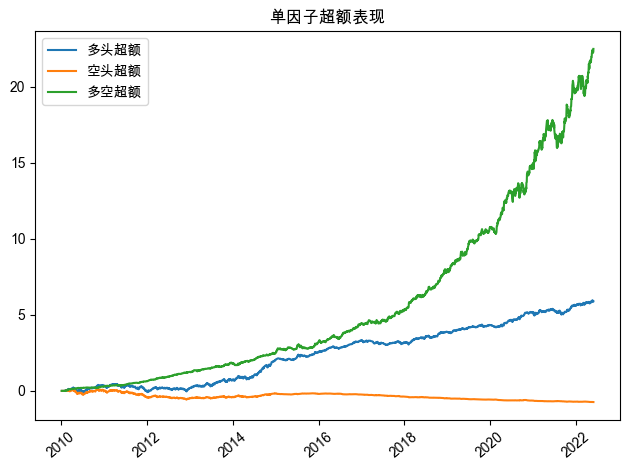

平均单边换手：0.784
年化交易成本:0.032 (未在超额中扣除)


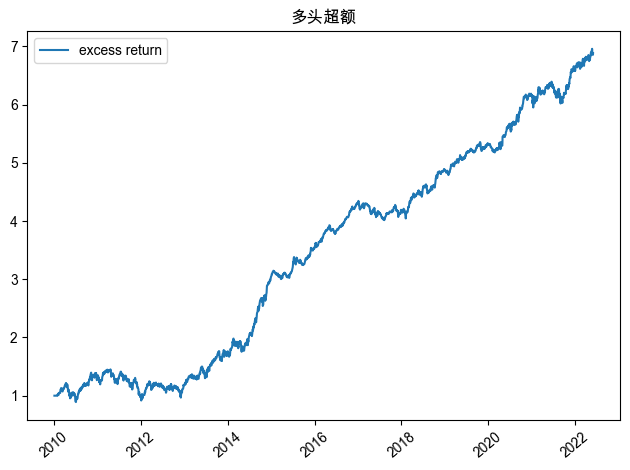

Rank IC: 8.20%
Rank ICIR: 1.31
t值: 15.92
年化收益率: 19.66%
年化波动率: 13.01%
信息比率: 1.51
最大回撤: 37.44%
均净动量比例: -0.0290
稳净动量比例: -0.3083


In [73]:
# 2.6
# 等权
factor_combined = (factor_volatility + factor_turnover) / 2
# 计算净动量比例
#stock_return = calculate_daily_returns(stock_close)
#future_return = stock_return.rolling(20).mean().shift(-20).lo[month_end_dates]

net_momentum_ratio = calculate_momentum_ratio(factor_combined,future_return)

# 分析因子表现
res = analyze_factor_performance(factor_combined, start_date, end_date)

net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") 
print(f"稳净动量比例: {stable_net_momentum:.4f}")

## 2.7 “日内反转-波动翻转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016    2017   2018  \
年化超额   0.3119 -0.2513 0.1422 0.3993 0.6255 0.0972 0.2141 -0.0077 0.2399   
波动率     0.2594  0.2483 0.2701 0.2334 0.1807 0.0685 0.0479  0.0526 0.0641   
最大回撤   0.3064  0.3653 0.2767 0.1714 0.1219 0.0497 0.0343  0.0369 0.0326   
夏普率     1.2028 -1.0119 0.5264 1.7109 3.4611 1.4183 4.4671 -0.1473 3.7413   
收益回撤比 1.0180 -0.6880 0.5139 2.3302 5.1329 1.9563 6.2474 -0.2099 7.3469   
半波       0.1648  0.1637 0.1602 0.1451 0.1122 0.0321 0.0241  0.0336 0.0350   
半夏普     1.8930 -1.5355 0.8875 2.7516 5.5752 3.0284 8.8724 -0.2309 6.8536   

             2019   2020   2021   2022   mean  
年化超额   0.0901 0.0387 0.0292 0.0359 0.1512  
波动率     0.0452 0.0712 0.0987 0.0844 0.1327  
最大回撤   0.0262 0.0635 0.1206 0.05

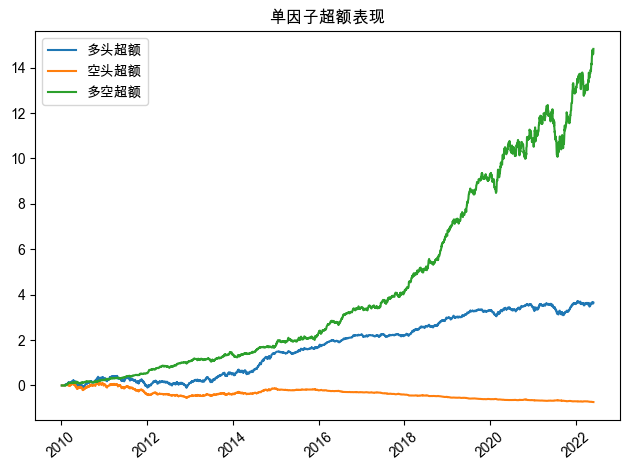

平均单边换手：0.792
年化交易成本:0.032 (未在超额中扣除)


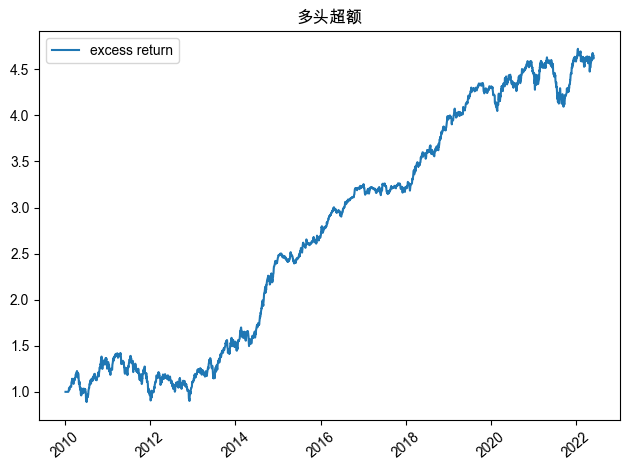

Rank IC: 6.89%
Rank ICIR: 0.80
t值: 9.79
年化收益率: 15.12%
年化波动率: 13.27%
信息比率: 1.14
最大回撤: 36.53%
均净动量比例: 0.0535
稳净动量比例: 0.5365


In [74]:
# 2.7
# 传统日内反转因子
with open('/Users/chenchen/Desktop/mycuhk/兴银/需要拷的数据/packages/frdata/stock_open.pkl', 'rb') as f:
    stock_open = pickle.load(f)

# 重新定义daily return为日内收益率
def calculate_daily_returns(stock_close, stock_open):
    """
    计算日内收益率（收盘/开盘 - 1）
    """
    return stock_close / stock_open - 1

# 1）计算每只股票 t 日的日内收益率
intraday_return = calculate_daily_returns(stock_close, stock_open)

# 2）每月月底，计算过去20日的均值 构建因子
reversal_factor_intra = intraday_return.rolling(20).mean().loc[month_end_dates]

# 计算净动量比例
#stock_return = calculate_daily_returns(stock_close)
future_return = intraday_return.rolling(20).mean().shift(-20).loc[month_end_dates]
net_momentum_ratio = calculate_momentum_ratio(reversal_factor_intra,future_return)

# 分析因子表现
res = analyze_factor_performance(reversal_factor_intra, start_date, end_date)

net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") 
print(f"稳净动量比例: {stable_net_momentum:.4f}")


load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015    2016   2017   2018  \
年化超额   0.2546 -0.2663 0.1906 0.3290 0.7814 0.1123  0.2384 0.0688 0.2498   
波动率     0.2615  0.2431 0.2637 0.2410 0.1803 0.0906  0.0435 0.0550 0.0549   
最大回撤   0.3067  0.3788 0.2228 0.1716 0.1081 0.1169  0.0204 0.0376 0.0297   
夏普率     0.9736 -1.0954 0.7228 1.3653 4.3342 1.2399  5.4845 1.2517 4.5532   
收益回撤比 0.8302 -0.7031 0.8556 1.9176 7.2312 0.9608 11.6746 1.8304 8.4138   
半波       0.1669  0.1605 0.1566 0.1493 0.1088 0.0457  0.0212 0.0362 0.0286   
半夏普     1.5253 -1.6596 1.2171 2.2046 7.1827 2.4585 11.2684 1.9028 8.7479   

             2019   2020   2021   2022   mean  
年化超额   0.0753 0.0816 0.0585 0.1290 0.1772  
波动率     0.0447 0.0563 0.0878 0.0847 0.1313  
最大回撤   0.0264 0.0285 0.0701 0.02

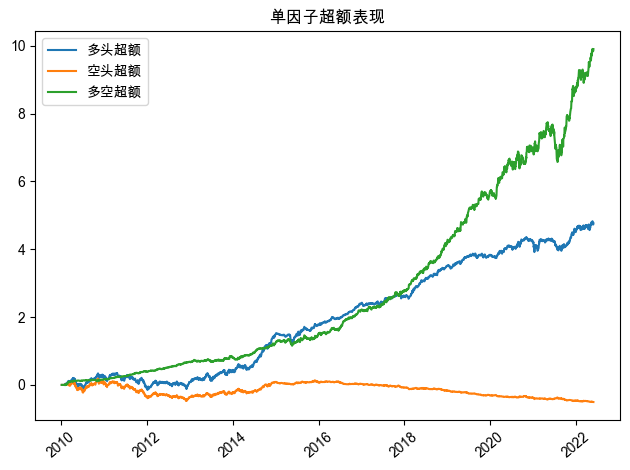

平均单边换手：0.788
年化交易成本:0.032 (未在超额中扣除)


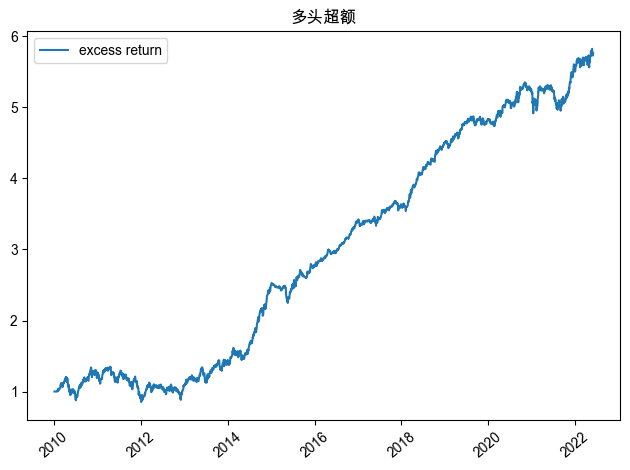

Rank IC: 4.95%
Rank ICIR: 0.81
t值: 9.80
年化收益率: 17.72%
年化波动率: 13.13%
信息比率: 1.35
最大回撤: 37.88%
均净动量比例: -0.0033
稳净动量比例: -0.0372


In [75]:
# 2.7
# 日内反转-波动翻转因子
def construct_reversal_volatility_factor(stock_close, stock_open, start_date, end_date):
    """
    构建日内反转-波动翻转因子
    """
    # 1. 计算日间收益率
    daily_returns = calculate_daily_returns(stock_close, stock_open)
    
    # 2. 计算月波动率和月收益率
    monthly_volatility = calculate_monthly_volatility(daily_returns)
    monthly_returns = calculate_monthly_returns(daily_returns)
    
    # 3. 获取月末日期
    month_end_dates = prepare_dates(start_date, end_date, fre='month')
    
    # 4. 构建因子
    factor_df = pd.DataFrame(index=month_end_dates, columns=stock_close.columns)
    
    #for date in month_end_dates:
    #    # 获取当月的波动率和收益率
    #    vol = monthly_volatility.loc[date]
    #    ret = monthly_returns.loc[date]
    #    
    #    # 计算市场截面均值
    #    market_vol_mean = vol.mean()
    #    
    #    # 根据波动率大小决定是否翻转因子值
    #    factor_values = ret.copy()
    #    factor_values[vol < market_vol_mean] *= -1  # 波动率小于均值的股票翻转因子值
    #    
    #    factor_df.loc[date] = factor_values
    # 向量化
    vol_data = monthly_volatility.loc[month_end_dates]
    ret_data = monthly_returns.loc[month_end_dates]
    # 计算市场截面均值
    market_vol_mean = vol_data.mean(axis=1)
    factor_values = np.where(
        vol_data.lt(market_vol_mean, axis=0),  
        -ret_data,                             
        ret_data                               
    )
    factor_df.loc[month_end_dates] = pd.DataFrame(
        factor_values, 
        index=month_end_dates, 
        columns=ret_data.columns
    )
    return factor_df

# 构建因子
factor_volatility_intra = construct_reversal_volatility_factor(stock_close, stock_open, start_date, end_date)

# 计算净动量比例
#stock_return = calculate_daily_returns(stock_close)
#future_return = stock_return.rolling(20).mean().shift(-20).loc[month_end_dates]

net_momentum_ratio = calculate_momentum_ratio(factor_volatility_intra, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_volatility_intra, start_date, end_date)

# 输出结果
#print("\n因子表现分析结果：")
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")


## 2.8 “日内反转-换手翻转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016   2017   2018  \
年化超额   0.3358 -0.2470 0.1433 0.4966 0.5991 0.1515 0.1959 0.0161 0.2252   
波动率     0.2541  0.2375 0.2554 0.2296 0.1752 0.0586 0.0393 0.0409 0.0479   
最大回撤   0.2949  0.3566 0.2358 0.1350 0.1144 0.0440 0.0251 0.0344 0.0308   
夏普率     1.3215 -1.0402 0.5612 2.1631 3.4196 2.5843 4.9893 0.3947 4.7042   
收益回撤比 1.1388 -0.6927 0.6079 3.6793 5.2369 3.4432 7.8026 0.4692 7.3201   
半波       0.1602  0.1552 0.1527 0.1402 0.1077 0.0274 0.0199 0.0260 0.0246   
半夏普     2.0968 -1.5918 0.9387 3.5428 5.5635 5.5336 9.8388 0.6207 9.1608   

             2019   2020   2021   2022   mean  
年化超额   0.0864 0.0312 0.0212 0.1535 0.1699  
波动率     0.0377 0.0460 0.0688 0.0774 0.1206  
最大回撤   0.0298 0.0430 0.0648 0.0216 0.356

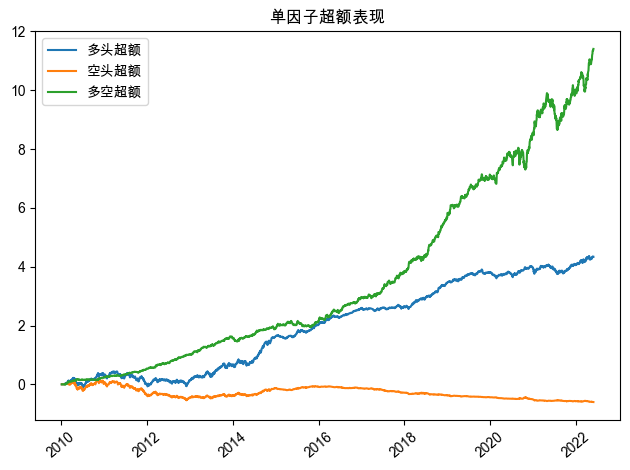

平均单边换手：0.791
年化交易成本:0.032 (未在超额中扣除)


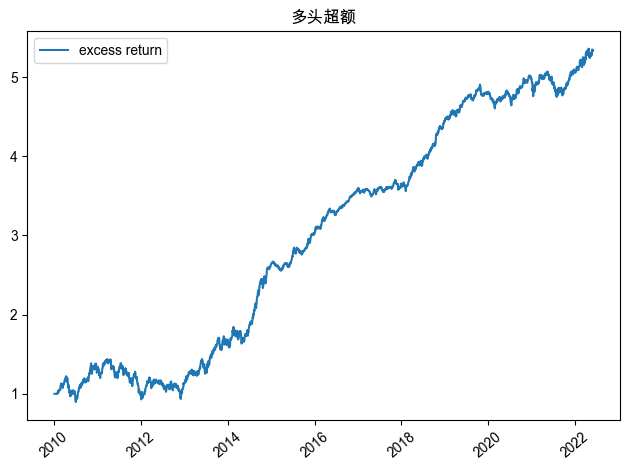

Rank IC: 6.33%
Rank ICIR: 1.11
t值: 13.44
年化收益率: 16.99%
年化波动率: 12.06%
信息比率: 1.41
最大回撤: 35.66%
均净动量比例: 0.0285
稳净动量比例: 0.3969


In [76]:
# 2.8
# 日内反转-换手翻转因子
def construct_reversal_turnover_factor(stock_close,stock_open, stock_turnover, start_date, end_date):

    # 1. 计算日内收益率
    daily_returns = calculate_daily_returns(stock_close, stock_open)
    # 2. 计算换手率变化量
    turnover_change = stock_turnover.diff()
    # 3. 获取月末日期
    month_end_dates = prepare_dates(start_date, end_date, fre='month')
    # 4. 构建翻转收益率
    flip_return = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns)
    #for date in daily_returns.index:
    #    tc = turnover_change.loc[date]
    #    market_tc_mean = tc.mean()
    #    flip = daily_returns.loc[date].copy()
    #    mask = (tc < market_tc_mean)
    #    mask = mask.reindex(flip.index)  # 对齐索引
    #    flip[mask.fillna(False)] *= -1
    #    flip_return.loc[date] = flip
    # 向量化
    tc_data = turnover_change.loc[daily_returns.index]
    returns_data = daily_returns.copy()
    market_tc_mean = tc_data.mean(axis=1)
    flip_condition = tc_data.lt(market_tc_mean, axis=0)
    flip_condition = flip_condition.reindex(columns=returns_data.columns, fill_value=False)
    flip_return_data = np.where(flip_condition.fillna(False), -returns_data, returns_data)
    flip_return.loc[daily_returns.index] = pd.DataFrame(flip_return_data, index=daily_returns.index, columns=returns_data.columns)
    # 5. 每月月底，计算最近20天的翻转收益率均值
    factor_df = flip_return.rolling(20).mean().loc[month_end_dates]
    return factor_df
#  构建因子
factor_turnover_intra = construct_reversal_turnover_factor(stock_close, stock_open, stock_turnover, start_date, end_date)

net_momentum_ratio = calculate_momentum_ratio(factor_turnover_intra, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_turnover_intra, start_date, end_date)

# 输出结果
#print("\n因子表现分析结果：")
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")

## 2.9 “修正日内反转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015    2016   2017   2018  \
年化超额   0.3196 -0.2389 0.1987 0.4766 0.7492 0.1861  0.2668 0.0363 0.2854   
波动率     0.2577  0.2419 0.2620 0.2399 0.1814 0.0760  0.0383 0.0540 0.0582   
最大回撤   0.2924  0.3561 0.2134 0.1532 0.1067 0.0605  0.0171 0.0439 0.0371   
夏普率     1.2402 -0.9875 0.7583 1.9865 4.1306 2.4476  6.9719 0.6725 4.9057   
收益回撤比 1.0930 -0.6708 0.9310 3.1113 7.0215 3.0754 15.6377 0.8275 7.6875   
半波       0.1621  0.1577 0.1555 0.1473 0.1097 0.0360  0.0195 0.0371 0.0296   
半夏普     1.9710 -1.5152 1.2773 3.2349 6.8293 5.1745 13.6784 0.9804 9.6403   

             2019   2020   2021   2022   mean  
年化超额   0.1086 0.1320 0.0410 0.1238 0.2065  
波动率     0.0377 0.0554 0.0746 0.0742 0.1270  
最大回撤   0.0252 0.0333 0.0661 0.02

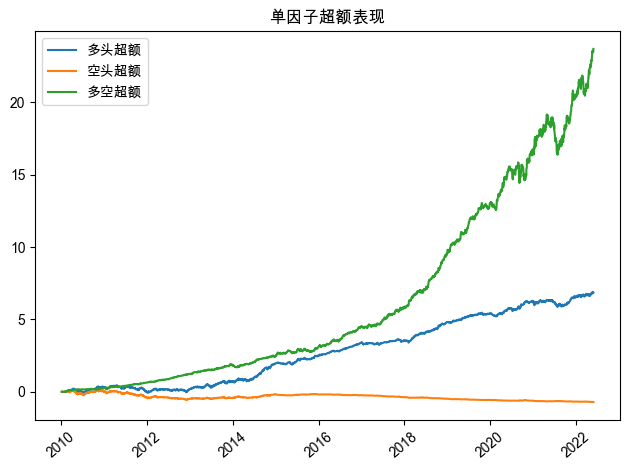

平均单边换手：0.782
年化交易成本:0.032 (未在超额中扣除)


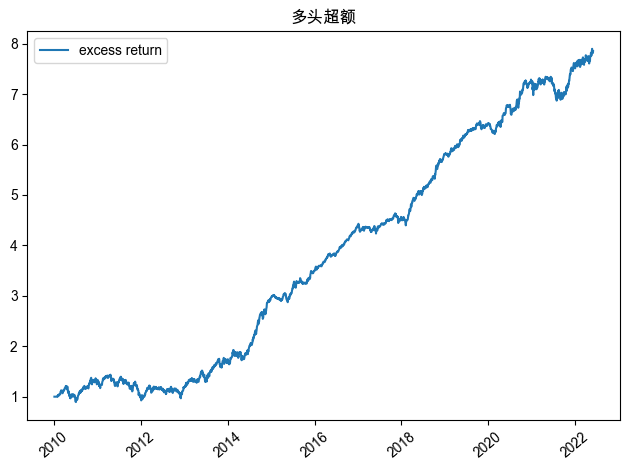

Rank IC: 7.08%
Rank ICIR: 1.14
t值: 13.90
年化收益率: 20.65%
年化波动率: 12.70%
信息比率: 1.63
最大回撤: 35.61%
均净动量比例: 0.0294
稳净动量比例: 0.3255


In [77]:
# 2.9
# 修正日内反转
# 等权
factor_combined_intra = (factor_volatility_intra + factor_turnover_intra) / 2

net_momentum_ratio = calculate_momentum_ratio(factor_combined_intra,future_return)

# 分析因子表现
res = analyze_factor_performance(factor_combined_intra, start_date, end_date)

net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") 
print(f"稳净动量比例: {stable_net_momentum:.4f}")

## 2.10 “隔夜距离”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014    2015   2016    2017   2018  \
年化超额   0.2239 -0.3044 0.0168 0.3259 0.5419 -0.0496 0.0982 -0.0136 0.1116   
波动率     0.2596  0.2333 0.2487 0.2396 0.1884  0.0614 0.0405  0.0383 0.0596   
最大回撤   0.3218  0.4177 0.3047 0.1529 0.1402  0.0943 0.0221  0.0425 0.0361   
夏普率     0.8628 -1.3050 0.0677 1.3602 2.8755 -0.8078 2.4253 -0.3552 1.8719   
收益回撤比 0.6958 -0.7289 0.0553 2.1316 3.8652 -0.5261 4.4404 -0.3200 3.0937   
半波       0.1676  0.1565 0.1516 0.1473 0.1185  0.0356 0.0208  0.0237 0.0368   
半夏普     1.3364 -1.9447 0.1111 2.2119 4.5739 -1.3926 4.7299 -0.5745 3.0330   

              2019    2020   2021   2022   mean  
年化超额   -0.0086 -0.0261 0.0494 0.0183 0.0757  
波动率      0.0530  0.0737 0.0721 0.1056 0.1287  
最大回撤    0.0431  0.

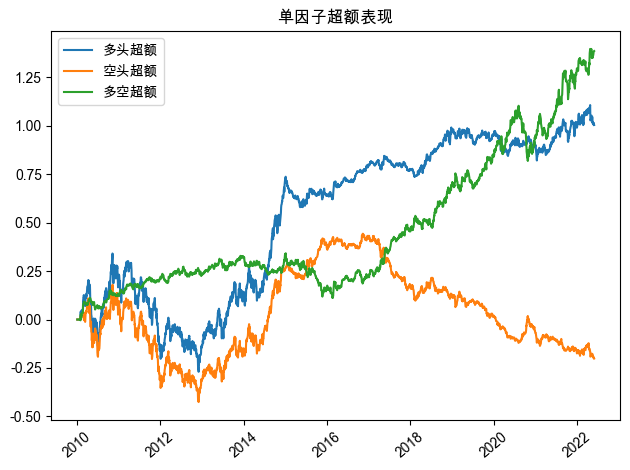

平均单边换手：0.762
年化交易成本:0.031 (未在超额中扣除)


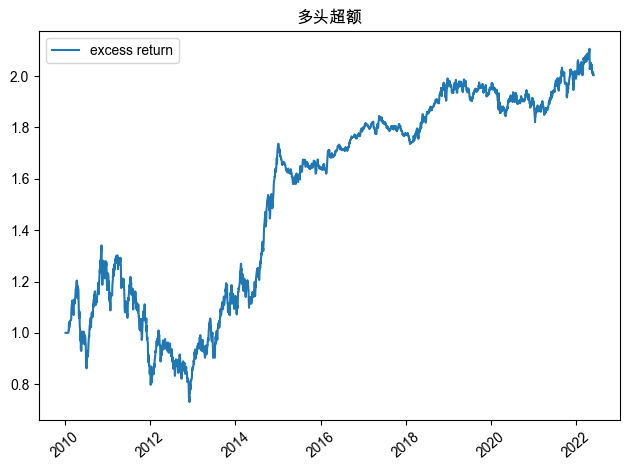

Rank IC: 2.69%
Rank ICIR: 0.66
t值: 8.01
年化收益率: 7.57%
年化波动率: 12.87%
信息比率: 0.59
最大回撤: 41.77%
均净动量比例: 0.1622
稳净动量比例: 2.7657


In [81]:
# 2.10
# 传统隔夜涨跌因子
# 重新定义daily return为隔夜收益率
def calculate_daily_returns(stock_close, stock_open):
    """
    计算隔夜收益率
    """
    return stock_open / stock_close.shift(1) - 1

# 1）计算每只股票 t 日的隔夜收益率
overnight_return = calculate_daily_returns(stock_close, stock_open)

# 2）每月月底，计算过去20日的均值 构建因子
reversal_factor_overnight = overnight_return.rolling(20).mean().loc[month_end_dates]

# 计算净动量比例
#stock_return = calculate_daily_returns(stock_close)
future_return = overnight_return.rolling(20).mean().shift(-20).loc[month_end_dates]
net_momentum_ratio = calculate_momentum_ratio(reversal_factor_overnight,future_return)

# 分析因子表现
res = analyze_factor_performance(-reversal_factor_overnight, start_date, end_date)

net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") 
print(f"稳净动量比例: {stable_net_momentum:.4f}")


load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013    2014   2015   2016   2017   2018  \
年化超额   0.2182 -0.2485 0.1043 0.4164  0.8342 0.0471 0.1895 0.0729 0.1618   
波动率     0.2565  0.2331 0.2579 0.2268  0.1749 0.0888 0.0509 0.0316 0.0507   
最大回撤   0.3152  0.3789 0.2724 0.1607  0.0802 0.1177 0.0332 0.0256 0.0338   
夏普率     0.8508 -1.0660 0.4045 1.8358  4.7691 0.5301 3.7209 2.3028 3.1927   
收益回撤比 0.6924 -0.6560 0.3829 2.5911 10.3997 0.3998 5.7078 2.8464 4.7878   
半波       0.1669  0.1559 0.1546 0.1387  0.1043 0.0446 0.0249 0.0158 0.0292   
半夏普     1.3075 -1.5944 0.6747 3.0012  7.9957 1.0539 7.6096 4.6110 5.5329   

             2019    2020   2021   2022   mean  
年化超额   0.0201 -0.0180 0.0594 0.3506 0.1698  
波动率     0.0403  0.0777 0.1098 0.1338 0.1333  
最大回撤   0.0399  0.0632 0.1095 

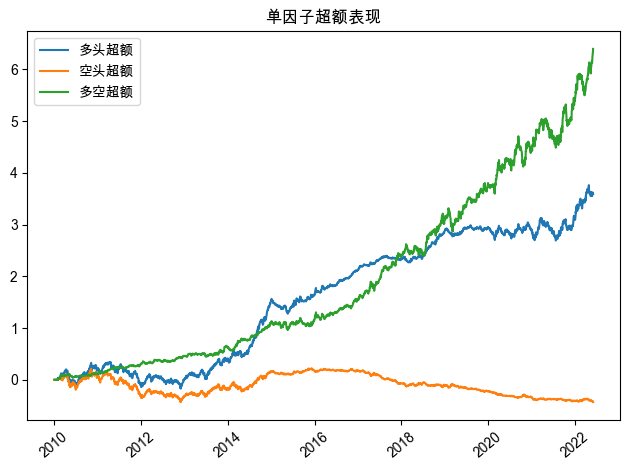

平均单边换手：0.668
年化交易成本:0.026 (未在超额中扣除)


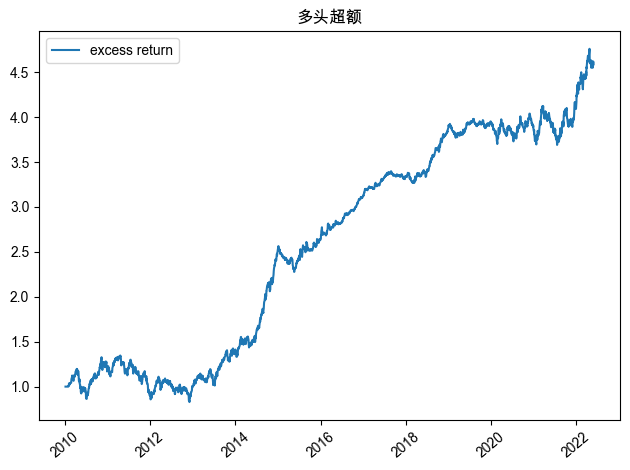

Rank IC: 6.15%
Rank ICIR: 0.86
t值: 10.43
年化收益率: 16.98%
年化波动率: 13.33%
信息比率: 1.27
最大回撤: 37.89%
均净动量比例: -0.1656
稳净动量比例: -1.7752


In [89]:
# 隔夜距离因子
overnight_return = calculate_daily_returns(stock_close, stock_open)
market_mean = overnight_return.mean(axis=1)  # 每天所有股票的均值，得到一个Series
overnight_distance = overnight_return.sub(market_mean, axis=0).abs()  # 每个股票的隔夜收益率减去市场均值
overnight_distance_factor = overnight_distance.rolling(20).mean().loc[month_end_dates]  # 计算20日滚动均值

net_momentum_ratio = calculate_momentum_ratio(overnight_distance_factor,future_return)

# 分析因子表现
res = analyze_factor_performance(overnight_distance_factor, start_date, end_date)

net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") 
print(f"稳净动量比例: {stable_net_momentum:.4f}")


## 2.11 “隔夜反转-波动翻转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016    2017   2018  \
年化超额   0.2584 -0.3165 0.0402 0.4779 0.6807 0.0742 0.0462 -0.0695 0.1359   
波动率     0.2670  0.2443 0.2622 0.2472 0.1952 0.0548 0.0354  0.0539 0.0689   
最大回撤   0.3148  0.4367 0.2945 0.1333 0.1215 0.0632 0.0457  0.1055 0.0457   
夏普率     0.9679 -1.2956 0.1533 1.9333 3.4861 1.3541 1.3072 -1.2906 1.9737   
收益回撤比 0.8209 -0.7247 0.1365 3.5856 5.6012 1.1742 1.0118 -0.6590 2.9726   
半波       0.1714  0.1629 0.1632 0.1474 0.1200 0.0311 0.0213  0.0354 0.0406   
半夏普     1.5075 -1.9423 0.2464 3.2422 5.6744 2.3904 2.1728 -1.9626 3.3490   

             2019   2020   2021   2022   mean  
年化超额   0.0603 0.0480 0.0056 0.1250 0.1205  
波动率     0.0596 0.0560 0.0710 0.1168 0.1332  
最大回撤   0.0413 0.0534 0.0483 0.03

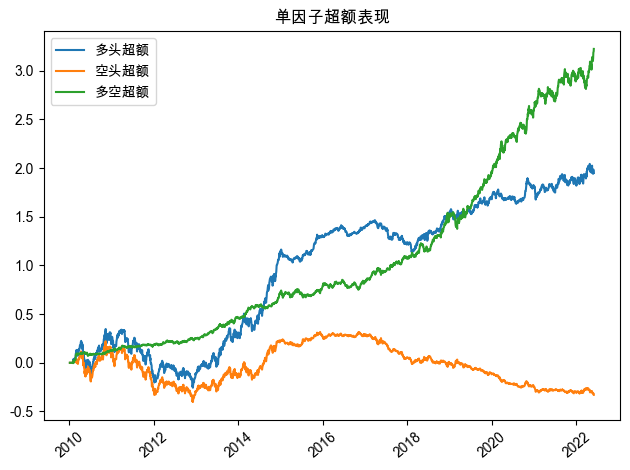

平均单边换手：0.718
年化交易成本:0.029 (未在超额中扣除)


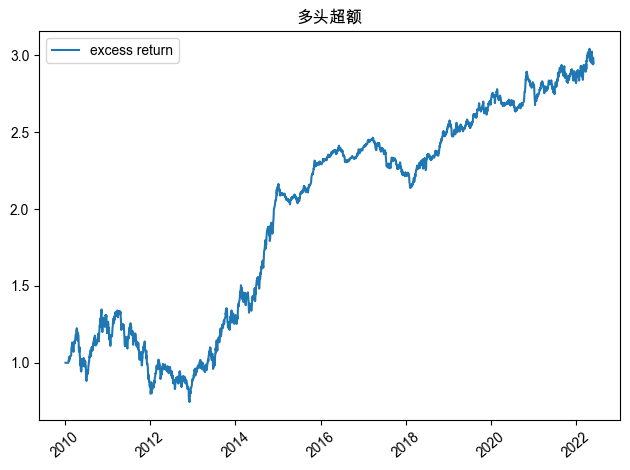

Rank IC: 3.20%
Rank ICIR: 0.72
t值: 8.73
年化收益率: 12.05%
年化波动率: 13.32%
信息比率: 0.90
最大回撤: 43.67%
均净动量比例: -0.1555
稳净动量比例: -1.4840


In [90]:
# 2.11
# 隔夜涨跌-波动翻转因子
# 构建因子
def construct_reversal_volatility_factor(overnight_distance, start_date, end_date):
    """
    构建隔夜反转-波动翻转因子
    """
    # 1. 计算20天窗口的均值和波动率
    monthly_distance = overnight_distance.rolling(20).mean()
    monthly_volatility = overnight_distance.rolling(20).std()
    # 2. 获取月末日期
    month_end_dates = prepare_dates(start_date, end_date, fre='month')
    # 3. 构建因子
    factor_df = pd.DataFrame(index=month_end_dates, columns=overnight_distance.columns)
    #for date in month_end_dates:
    #    dist = monthly_distance.loc[date]
    #    vol = monthly_volatility.loc[date]
    #    market_vol_mean = vol.mean()
    #    factor_values = dist.copy()
    #    factor_values[vol < market_vol_mean] *= -1  # 波动率小于均值的股票翻转因子值
    #    factor_df.loc[date] = factor_values
    # 向量化
    dist_data = monthly_distance.loc[month_end_dates]
    vol_data = monthly_volatility.loc[month_end_dates]
    market_vol_mean = vol_data.mean(axis=1)
    factor_values = np.where(vol_data.lt(market_vol_mean, axis=0), -dist_data, dist_data)
    factor_df.loc[month_end_dates] = pd.DataFrame(factor_values, index=month_end_dates, columns=dist_data.columns)
    return factor_df

factor_volatility_overnight = construct_reversal_volatility_factor(overnight_distance, start_date, end_date)


net_momentum_ratio = calculate_momentum_ratio(factor_volatility_overnight, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_volatility_overnight, start_date, end_date)

# 输出结果
#print("\n因子表现分析结果：")
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")


In [ ]:
# 2.1(5)
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}")
print(f"稳净动量比例: {stable_net_momentum:.4f}")

均净动量比例: -0.0144
稳净动量比例: -0.1230


## 2.12 “隔夜反转-换手翻转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016   2017   2018  \
年化超额   0.2828 -0.2513 0.1234 0.5321 0.6899 0.0887 0.1768 0.0216 0.1193   
波动率     0.2466  0.2202 0.2375 0.2160 0.1669 0.0654 0.0384 0.0332 0.0410   
最大回撤   0.2868  0.3517 0.2077 0.1519 0.0837 0.0623 0.0340 0.0257 0.0192   
夏普率     1.1470 -1.1411 0.5195 2.4638 4.1337 1.3564 4.6048 0.6495 2.9113   
收益回撤比 0.9863 -0.7145 0.5940 3.5021 8.2399 1.4234 5.1944 0.8388 6.2181   
半波       0.1582  0.1458 0.1458 0.1290 0.1018 0.0335 0.0199 0.0170 0.0233   
半夏普     1.7878 -1.7235 0.8464 4.1243 6.7748 2.6447 8.8950 1.2696 5.1114   

             2019   2020   2021   2022   mean  
年化超额   0.0752 0.0675 0.0723 0.0641 0.1586  
波动率     0.0396 0.0542 0.0652 0.0874 0.1163  
最大回撤   0.0233 0.0397 0.0507 0.0391 0.351

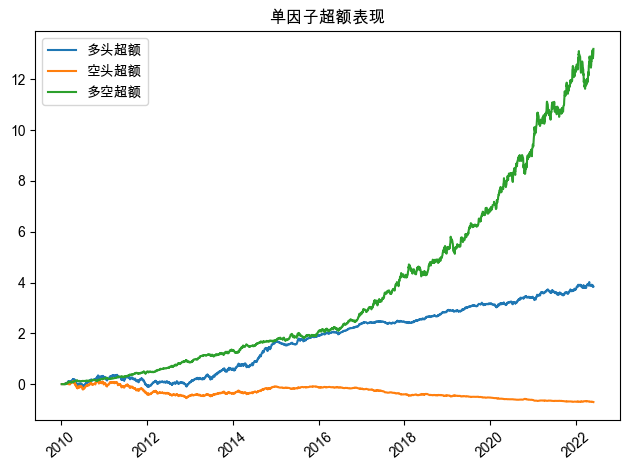

平均单边换手：0.691
年化交易成本:0.027 (未在超额中扣除)


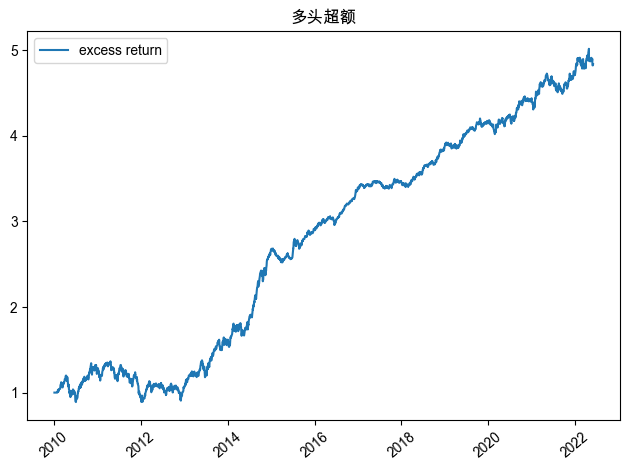

Rank IC: 7.13%
Rank ICIR: 1.06
t值: 12.88
年化收益率: 15.86%
年化波动率: 11.63%
信息比率: 1.36
最大回撤: 35.17%
均净动量比例: -0.1733
稳净动量比例: -2.3428


In [91]:
# 2.12
# 隔夜涨跌-换手翻转因子
def construct_reversal_turnover_factor(overnight_distance,stock_turnover, start_date, end_date):
    """
    构建隔夜反转-换手翻转因子
    """
    # 1. overnight_distance
    
    # 2. 计算换手率变化量& 换手率距离
    turnover_change = stock_turnover.diff()
    turnover_change_mean = turnover_change.mean(axis=1)
    turnover_distance = (turnover_change.sub(turnover_change_mean, axis=0)).abs()
    # 3. 获取月末日期
    month_end_dates = prepare_dates(start_date, end_date, fre='month')
    # 4. 构建翻转收益率
    flip_return = pd.DataFrame(index=overnight_distance.index, columns=overnight_distance.columns)
    #for date in overnight_distance.index:
    #    tc = turnover_distance.loc[date]
    #    market_tc_mean = tc.mean()
    #    flip = overnight_distance.loc[date].copy()
    #    mask = (tc < market_tc_mean)
    #    mask = mask.reindex(flip.index)  # 对齐索引
    #    flip[mask.fillna(False)] *= -1
    #    flip_return.loc[date] = flip
    # 向量化
    # 获取数据
    tc_data = turnover_distance.loc[overnight_distance.index]
    overnight_data = overnight_distance.loc[overnight_distance.index]
    market_tc_mean = tc_data.mean(axis=1)
    flip_condition = tc_data.lt(market_tc_mean, axis=0)
    flip_condition = flip_condition.reindex(columns=overnight_data.columns, fill_value=False)
    flip_data = np.where(
        flip_condition.fillna(False), 
        -overnight_data,              
        overnight_data                
    )
    flip_return.loc[overnight_distance.index] = pd.DataFrame(
        flip_data,
        index=overnight_distance.index,
        columns=overnight_data.columns
    )
        # 5. 每月月底，计算最近20天的翻转收益率均值
    factor_df = flip_return.rolling(20).mean().loc[month_end_dates]
    return factor_df
# 构建因子
factor_turnover_overnight = construct_reversal_turnover_factor(overnight_distance, stock_turnover, start_date, end_date)

net_momentum_ratio = calculate_momentum_ratio(factor_turnover_overnight, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_turnover_overnight, start_date, end_date)   

# 输出结果
#print("\n因子表现分析结果：")
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")





## 2.13 “修正隔夜反转”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015    2016    2017   2018  \
年化超额   0.3149 -0.2588 0.1231 0.5360 0.7514 0.0885  0.1460 -0.0078 0.1731   
波动率     0.2533  0.2263 0.2430 0.2210 0.1735 0.0478  0.0309  0.0311 0.0454   
最大回撤   0.2901  0.3624 0.2179 0.1269 0.0878 0.0437  0.0127  0.0341 0.0220   
夏普率     1.2432 -1.1437 0.5067 2.4252 4.3317 1.8537  4.7332 -0.2500 3.8106   
收益回撤比 1.0855 -0.7140 0.5651 4.2225 8.5544 2.0254 11.5248 -0.2275 7.8544   
半波       0.1608  0.1503 0.1488 0.1318 0.1054 0.0245  0.0147  0.0185 0.0232   
半夏普     1.9582 -1.7214 0.8275 4.0664 7.1269 3.6116  9.9585 -0.4201 7.4515   

             2019   2020   2021   2022   mean  
年化超额   0.0985 0.0527 0.0808 0.1522 0.1731  
波动率     0.0437 0.0492 0.0659 0.1095 0.1185  
最大回撤   0.0350 0.0383 0.0

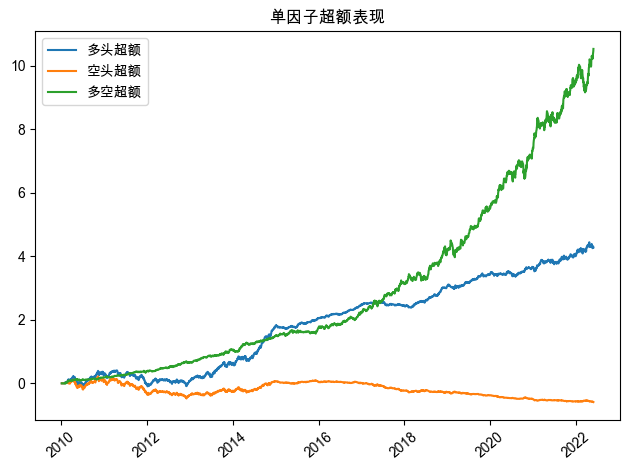

平均单边换手：0.692
年化交易成本:0.027 (未在超额中扣除)


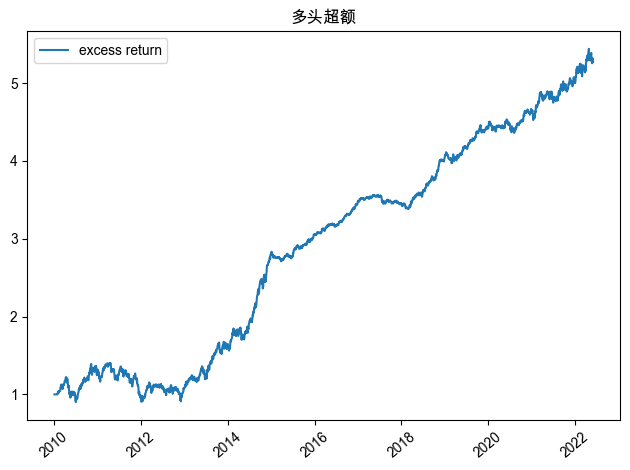

Rank IC: 5.77%
Rank ICIR: 1.22
t值: 14.81
年化收益率: 17.31%
年化波动率: 11.85%
信息比率: 1.46
最大回撤: 36.24%
均净动量比例: -0.1573
稳净动量比例: -1.5643


In [92]:
# 2.13
# 修正隔夜反转因子
# 等权
factor_combined_overnight = (factor_volatility_overnight + factor_turnover_overnight) / 2

net_momentum_ratio = calculate_momentum_ratio(factor_combined_overnight, future_return)
# 分析因子表现
res = analyze_factor_performance(factor_combined_overnight, start_date, end_date)   

# 输出结果
#print("\n因子表现分析结果：")
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")

## 2.14 “球队银币”因子

load data locally from 2009-01-05 to 2025-04-15
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015    2016   2017    2018  \
年化超额   0.3448 -0.2400 0.2210 0.5140 0.8118 0.1857  0.2946 0.0525  0.2994   
波动率     0.2544  0.2375 0.2595 0.2353 0.1778 0.0732  0.0405 0.0511  0.0536   
最大回撤   0.2881  0.3558 0.2016 0.1501 0.0891 0.0468  0.0227 0.0350  0.0348   
夏普率     1.3553 -1.0106 0.8518 2.1843 4.5671 2.5372  7.2737 1.0275  5.5915   
收益回撤比 1.1968 -0.6745 1.0964 3.4238 9.1076 3.9669 12.9760 1.4985  8.6022   
半波       0.1594  0.1558 0.1528 0.1431 0.1062 0.0333  0.0200 0.0336  0.0265   
半夏普     2.1638 -1.5408 1.4458 3.5917 7.6442 5.5735 14.7179 1.5621 11.2827   

             2019   2020   2021   2022   mean  
年化超额   0.1152 0.1785 0.0988 0.1678 0.2342  
波动率     0.0363 0.0536 0.0704 0.0734 0.1243  
最大回撤   0.0266 0.0308 0.0

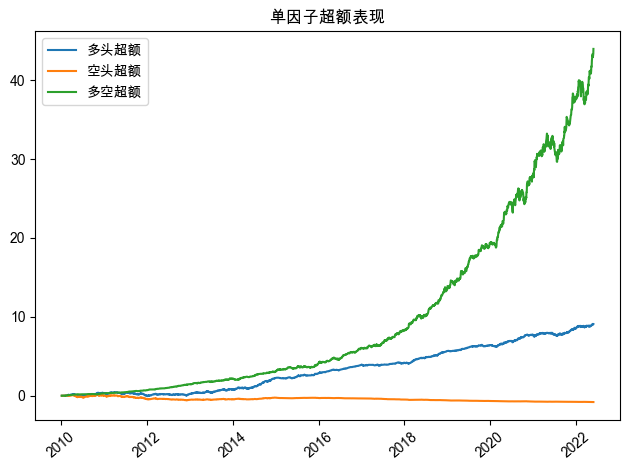

平均单边换手：0.772
年化交易成本:0.031 (未在超额中扣除)


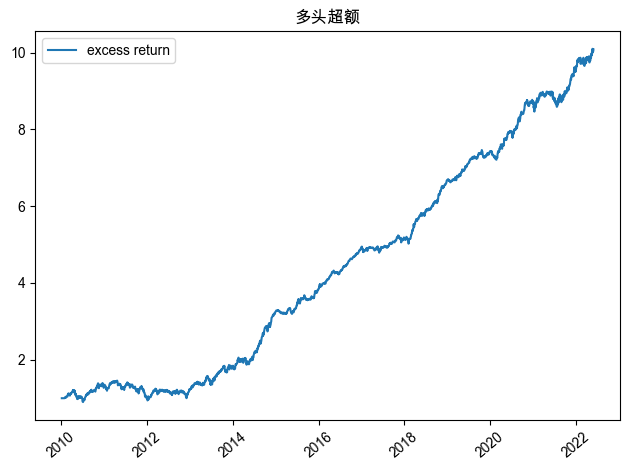

Rank IC: 8.52%
Rank ICIR: 1.29
t值: 15.74
年化收益率: 23.42%
年化波动率: 12.43%
信息比率: 1.88
最大回撤: 35.58%
均净动量比例: -0.1479
稳净动量比例: -1.9717


In [93]:
# 2.14
# 球队硬币因子
factor_team_coin = (factor_combined+factor_combined_intra+factor_combined_overnight)/3

net_momentum_ratio = calculate_momentum_ratio(factor_team_coin, future_return)

# 分析因子表现
res = analyze_factor_performance(factor_team_coin, start_date, end_date)
net_momentum_ratio = np.array(net_momentum_ratio)
# 均净动量比例
mean_net_momentum = np.nanmean(net_momentum_ratio)
# 稳净动量比例
std_net_momentum = np.nanstd(net_momentum_ratio)
if std_net_momentum > 0:
    stable_net_momentum = mean_net_momentum / std_net_momentum
else:
    stable_net_momentum = np.nan

print(f"均净动量比例: {mean_net_momentum:.4f}") # 衡量市场整体是“动量效应”占主导，还是“反转效应”占主导。
print(f"稳净动量比例: {stable_net_momentum:.4f}")

In [ ]:
# 2.15 剥离其他风格因子影响后“球队硬币” ？没有其他因子的数据

## 2.16 “球队硬币”因子在不同样本空间下的表现

load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015   2016    2017   2018  \
年化超额   0.2449 -0.0198 0.0428 0.1353 0.0601 0.3559 0.0633 -0.0781 0.0060   
波动率     0.0939  0.0592 0.0729 0.0691 0.0803 0.1228 0.0844  0.0598 0.0835   
最大回撤   0.0542  0.0894 0.0590 0.0310 0.1004 0.0719 0.0548  0.1017 0.0860   
夏普率     2.6081 -0.3340 0.5869 1.9588 0.7488 2.8984 0.7501 -1.3063 0.0717   
收益回撤比 4.5205 -0.2211 0.7258 4.3644 0.5988 4.9502 1.1567 -0.7679 0.0696   
半波       0.0438  0.0344 0.0425 0.0421 0.0531 0.0773 0.0535  0.0400 0.0493   
半夏普     5.5847 -0.5749 1.0076 3.2113 1.1332 4.6066 1.1838 -1.9509 0.1214   

              2019   2020   2021   2022   mean  
年化超额   -0.0031 0.1154 0.1172 0.0629 0.0848  
波动率      0.0739 0.0752 0.0736 0.0828 0.0793  
最大回撤    0.0539 0.0462 0.0325 0.0420 0.1017  
夏普率     -0.0415 1.5344 1.5930 0.

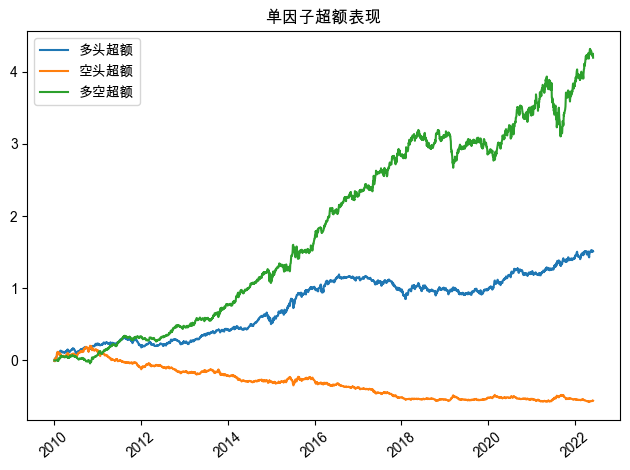

平均单边换手：0.635
年化交易成本:0.025 (未在超额中扣除)


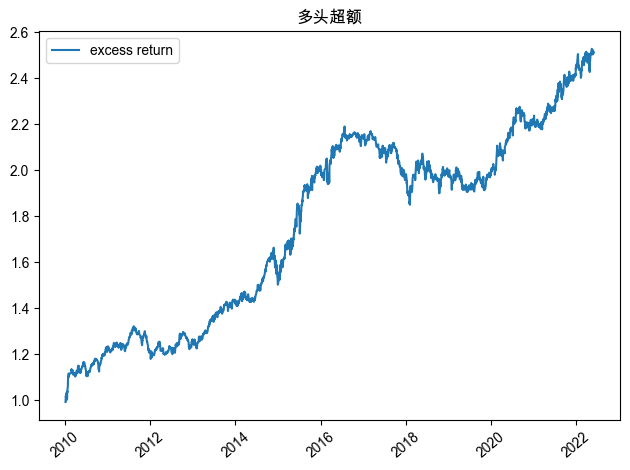

沪深300 多头组合年化超额收益: 8.48%
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2010    2011   2012   2013   2014   2015    2016   2017   2018  \
年化超额   0.1000  0.1062 0.0873 0.1118 0.1031 0.1397  0.1432 0.0481 0.0575   
波动率     0.0939  0.0282 0.0356 0.0346 0.0281 0.0491  0.0284 0.0271 0.0353   
最大回撤   0.0808  0.0092 0.0170 0.0191 0.0115 0.0172  0.0158 0.0111 0.0204   
夏普率     1.0653  3.7681 2.4490 3.2272 3.6695 2.8427  5.0424 1.7723 1.6295   
收益回撤比 1.2376 11.4980 5.1191 5.8626 8.9905 8.1368  9.0546 4.3221 2.8155   
半波       0.0487  0.0134 0.0186 0.0187 0.0138 0.0259  0.0140 0.0147 0.0200   
半夏普     2.0518  7.9491 4.6876 5.9884 7.4601 5.3938 10.2142 3.2660 2.8745   

             2019   2020   2021   2022   mean  
年化超额   0.0059 0.0752 0.0592 0.1151 0.0886  
波动率     0.0284 0.0471 0.0569 0.0454 0.0414  
最大回撤   0.0237 0.0579 0.0411 0.0141 0.0808  
夏普率     0.20

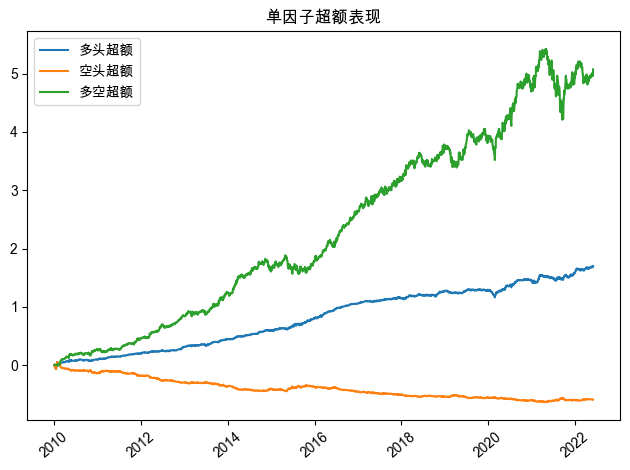

平均单边换手：0.544
年化交易成本:0.021 (未在超额中扣除)


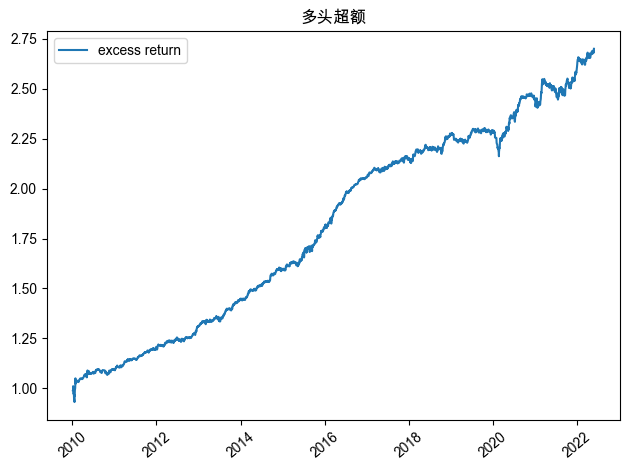

中证500 多头组合年化超额收益: 8.86%
load data locally from 2009-01-05 to 2025-04-15


KeyError: '000852'

In [95]:
# 2.16
# 指数池与benchmark、top的对应关系
pool_benchmark_top_map = {
    '000300': {'benchmark': 'b1', 'top': 100},   # 沪深300
    '000905': {'benchmark': 'b2', 'top': 300},   # 中证500
    '1000':   {'benchmark': 'b4', 'top': 300},   # 中证1000
    '1800':   {'benchmark': 'b3', 'top': 500},   # 800+1000
    '2000':   {'benchmark': 'b6', 'top': 500},   # 国证2000
    '888888': {'benchmark': 'b2', 'top': 300},   # 全A，默认
}
def get_benchmark_and_top(pool_code):
    # 支持TOP/TPCT等市值池
    if pool_code.startswith('TOP'):
        return 'b2', int(pool_code[3:]) 
    if pool_code.startswith('TPCT'):
        return 'b2', None               
    return (
        pool_benchmark_top_map.get(pool_code, {'benchmark': 'b2', 'top': 300})['benchmark'],
        pool_benchmark_top_map.get(pool_code, {'benchmark': 'b2', 'top': 300})['top']
    )
results = {}
for pool_code, pool_name in zip(['000300', '000905', '1000'], ['沪深300', '中证500', '中证1000']):
    benchmark, top = get_benchmark_and_top(pool_code)
    res = backtest_stand(
        -factor_team_coin,
        start=start_date,
        end=end_date,
        benchmark=benchmark,
        stock_pool=pool_code,
        barra_neutral=True,
        fre='month',
        top=top
    )
    annual_return = res['多空表现']['多头表现'].loc['年化超额', 'mean']
    print(f"{pool_name} 多头组合年化超额收益: {annual_return:.2%}")
    results[pool_name] = annual_return